
ANALYZING TARGET: Y_Breadth
Found existing results: ../../data/MRQAP_MultiModel_Analysis\MultiModel_Results_Y_Breadth.csv
Skipping calculation phase and regenerating plots...
Plot saved: ../../data/MRQAP_MultiModel_Analysis\Robustness_Plot_Y_Breadth.png

ANALYZING TARGET: Y_Intensity
[Y_Intensity] Common Countries: 49
>>> Step 1: Scanning all combinations via OLS...
Scanning all subsets (2048 combinations)...
Top 3 Best Models (by BIC):
                                                   vars           bic  \
1150  [Geo_Proximity, Ideal_Sim, GDP_Diff, Trade_Int...  10995.846054   
647   [Geo_Proximity, Ideal_Sim, GDP_Diff, Trade_Int...  10996.386750   
1615  [Geo_Proximity, Ideal_Sim, GDP_Diff, Trade_Int...  10998.510844   

            r2  
1150  0.287079  
647   0.284557  
1615  0.288622  

>>> Step 2: Running MRQAP for 6 Selected Models...
   Running M1: Baseline ...
   Running M2: +Pol/Econ ...
   Running M3: +Science (Full) ...
   Running M_Best_1 (BIC) ...
   Running M_Best_2 (BI

<Figure size 1400x1000 with 0 Axes>

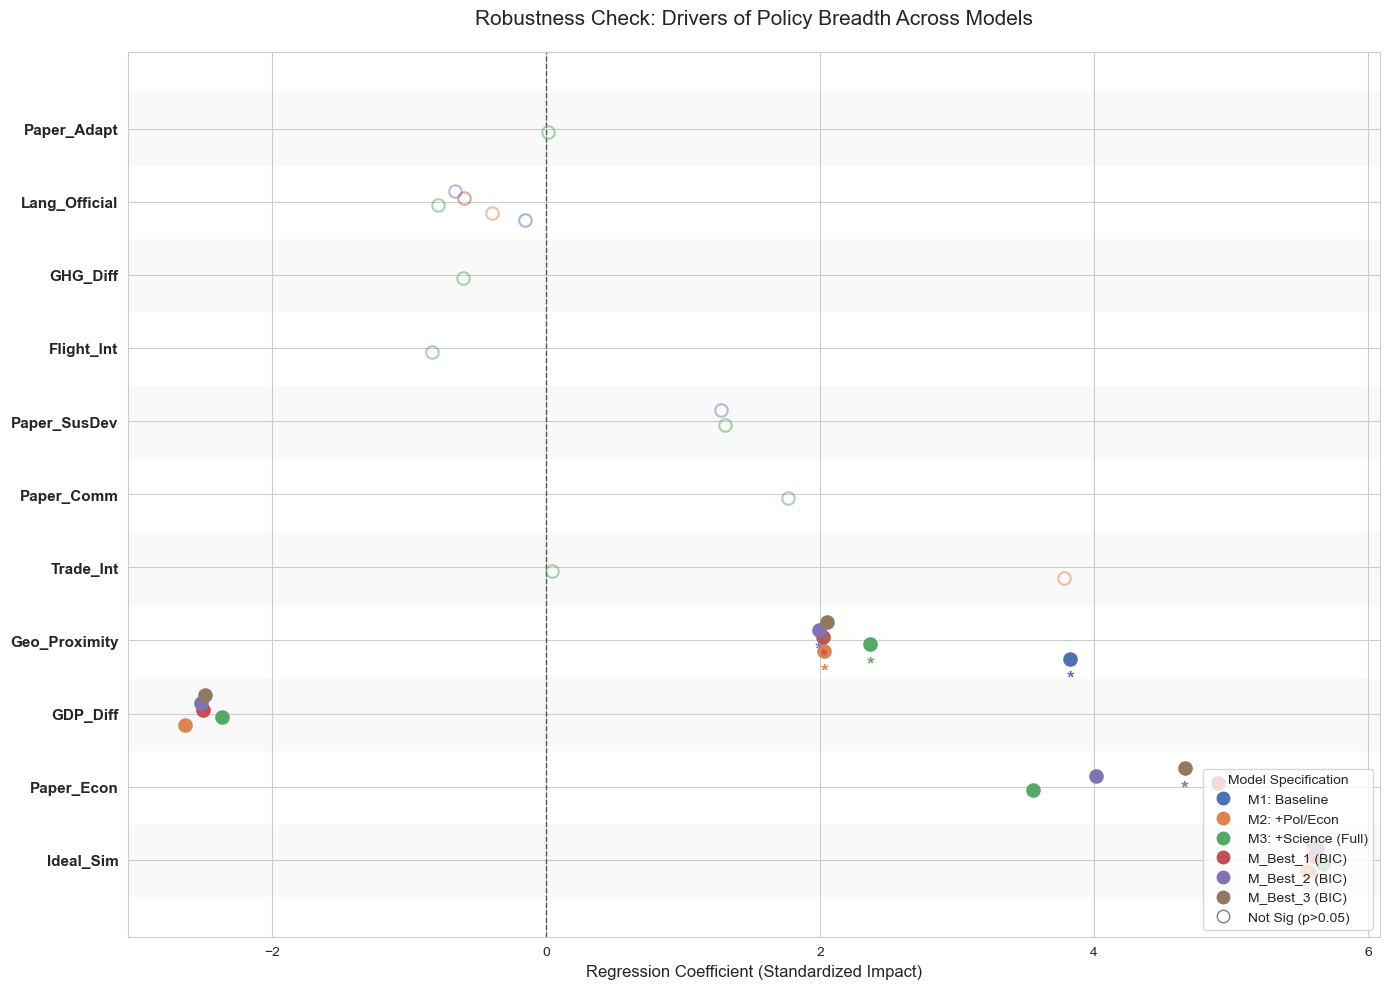

<Figure size 1400x1000 with 0 Axes>

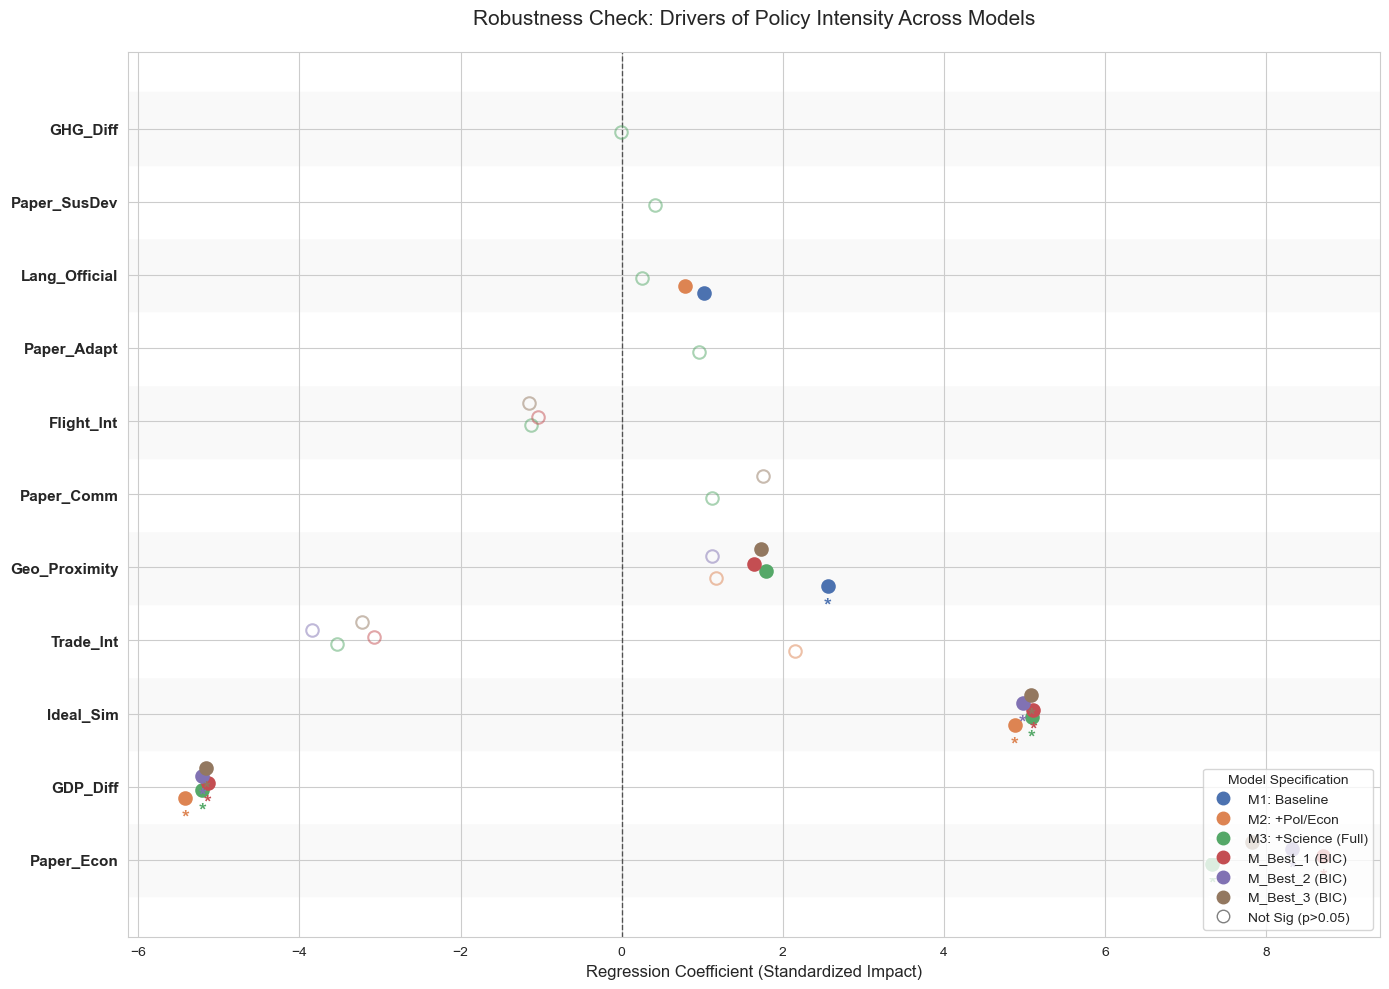

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import os
from itertools import combinations
# from tqdm import tqdm # 如果没有安装 tqdm 可以注释掉

# ==============================================================================
# 1. 基础配置
# ==============================================================================
INPUT_FOLDER = '../../data/PDF_data_Visual/Long_dataframe'
OUTPUT_FOLDER = '../../data/MRQAP_MultiModel_Analysis'

if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

# 变量映射
FILES_MAP = {
    'Y_Breadth': '4-1-overlapping_cluster_heatmap_Breadth_long.csv',
    'Y_Intensity': '4-1-overlapping_cluster_heatmap_Intensity_long.csv',

    # --- 解释变量 ---
    # [Geo & Lang]
    'Geo_Proximity': '1-3-norm_geographical_proximity_avg_long.csv',
    'Lang_Official': '1-4a-Common_Official_Language_long.csv',
    
    # [Politics]
    'Ideal_Sim': '1-1-norm_ideal_sim_2005_2023_long.csv',

    # [Econ & Connect]
    'GDP_Diff': '1-6-1-GDP_Diff_long.csv',
    'Trade_Int': '1-2-BACI_Trade_Intensity_Avg_long.csv',
    'Flight_Int': '1-5-AeroSCOPE_Flight_Intensity_long.csv',
    'GHG_Diff': '1-6-2-GHG_Diff_long.csv',

    # [Science - Sub-themes]
    'Paper_Econ': '1-7-T10471-Paper_collab-Climate_Change_Policy_and_Economics_long.csv',
    'Paper_Comm': '1-7-T11488-Paper_collab-Climate_Communication_and_Perception_long.csv',
    'Paper_SusDev': '1-7-T12013-Paper_collab-Sustainable_Development_and_Env_Policy_long.csv',
    'Paper_Adapt': '1-7-T12656-Paper_collab-Climate_Adaptation_and_Migration_long.csv',
}

# 需要 Log 转换的变量
LOG_VARS = [
    'Trade_Int', 'Flight_Int', 'GDP_Diff', 'GHG_Diff', 
    'Paper_Econ', 'Paper_Comm', 'Paper_SusDev', 'Paper_Adapt'
]

# ==============================================================================
# 2. 数据加载与对齐
# ==============================================================================
def load_and_align_data(target_y, all_x_vars):
    """读取并对齐数据，返回 Y 数组和 X 字典"""
    loaded = {}
    
    def _read(path):
        try:
            df = pd.read_csv(path)
            df.columns = [c.strip() for c in df.columns]
            df['Source'] = df['Source'].astype(str)
            df['Target'] = df['Target'].astype(str)
            return df.pivot(index='Source', columns='Target', values='Weight').fillna(0)
        except: return None

    y_path = os.path.join(INPUT_FOLDER, FILES_MAP[target_y])
    loaded['Y'] = _read(y_path)
    if loaded['Y'] is None: return None, None
    
    valid_xs = []
    for x in all_x_vars:
        path = os.path.join(INPUT_FOLDER, FILES_MAP[x])
        if os.path.exists(path):
            m = _read(path)
            if m is not None:
                loaded[x] = m
                valid_xs.append(x)
    
    common = loaded['Y'].index
    for x in valid_xs:
        common = common.intersection(loaded[x].index).intersection(loaded[x].columns)
    common = sorted(list(common))
    print(f"[{target_y}] Common Countries: {len(common)}")
    
    Y_arr = loaded['Y'].loc[common, common].values
    X_dict = {}
    for x in valid_xs:
        arr = loaded[x].loc[common, common].values
        if x in LOG_VARS:
            arr = np.log1p(np.abs(arr))
        X_dict[x] = arr
        
    return Y_arr, X_dict

# ==============================================================================
# 3. 核心工具：全排列 OLS 筛选
# ==============================================================================
def scan_all_combinations_ols(y_arr, x_dict, x_vars):
    n = y_arr.shape[0]
    mask = ~np.eye(n, dtype=bool)
    y_vec = y_arr[mask]
    x_vecs_pool = {k: x_dict[k][mask] for k in x_vars}
    
    results = []
    print(f"Scanning all subsets ({2**len(x_vars)} combinations)...")
    
    for k in range(1, len(x_vars) + 1):
        for combo in combinations(x_vars, k):
            X_mat = np.column_stack([x_vecs_pool[v] for v in combo])
            X_mat = sm.add_constant(X_mat)
            try:
                model = sm.OLS(y_vec, X_mat)
                res = model.fit()
                results.append({'vars': list(combo), 'bic': res.bic, 'r2': res.rsquared})
            except: pass
            
    return pd.DataFrame(results).sort_values('bic')

# ==============================================================================
# 4. 核心工具：MRQAP 置换检验
# ==============================================================================
def run_mrqap(y_arr, x_dict, model_vars, perms=2000):
    n = y_arr.shape[0]
    mask = ~np.eye(n, dtype=bool)
    y_vec = y_arr[mask]
    
    X = np.column_stack([x_dict[v][mask] for v in model_vars])
    X = sm.add_constant(X)
    
    obs_res = sm.OLS(y_vec, X).fit()
    obs_beta = obs_res.params
    obs_r2 = obs_res.rsquared
    
    perm_betas = np.zeros((perms, len(obs_beta)))
    perm_r2s = np.zeros(perms)
    y_temp = y_arr.copy()
    
    for i in range(perms):
        idx = np.random.permutation(n)
        y_shuf = y_temp[idx, :][:, idx]
        try:
            res = sm.OLS(y_shuf[mask], X).fit()
            perm_betas[i] = res.params
            perm_r2s[i] = res.rsquared
        except: pass
        
    p_vals = []
    for k in range(len(obs_beta)):
        p = (np.sum(np.abs(perm_betas[:, k]) >= np.abs(obs_beta[k])) + 1) / (perms + 1)
        p_vals.append(p)
        
    p_r2 = (np.sum(perm_r2s >= obs_r2) + 1) / (perms + 1)
    
    return pd.DataFrame({
        'Variable': ['Intercept'] + list(model_vars),
        'Coef': obs_beta,
        'P_Val': p_vals,
    }), obs_r2, p_r2

# ==============================================================================
# 5. [修复版] 高级可视化：稳健性森林图
# ==============================================================================
def plot_robustness(df, target_name):
    """
    绘制多模型对比图（修复了 groupby.abs() 的 bug）
    """
    plt.figure(figsize=(14, 10))
    sns.set_style("whitegrid")
    
    # --- 修复点：先计算绝对值列，再聚合 ---
    # 创建副本以免影响原始数据
    df_plot = df.copy()
    df_plot['Abs_Coef'] = df_plot['Coef'].abs()
    
    # 按系数绝对值的均值排序变量
    var_order = df_plot.groupby('Variable')['Abs_Coef'].mean().sort_values(ascending=False).index
    
    # 颜色配置
    models = df['Model_Name'].unique()
    # 使用 colorblind 友好色板
    palette = sns.color_palette("deep", len(models))
    color_map = dict(zip(models, palette))
    
    # 绘图区域
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Y轴基准位置
    y_base = np.arange(len(var_order))
    # 模型偏移量 (让点不重叠)
    offsets = np.linspace(-0.25, 0.25, len(models))
    
    # 绘制参考线 (0线)
    ax.axvline(0, color='black', linestyle='--', alpha=0.6, linewidth=1)
    # 绘制背景条纹
    for y in y_base:
        ax.axhspan(y - 0.5, y + 0.5, color='#f9f9f9' if y % 2 == 0 else 'white', zorder=0)

    # 循环绘制每个点
    for idx_m, model in enumerate(models):
        subset = df[df['Model_Name'] == model]
        
        for idx_v, var in enumerate(var_order):
            row = subset[subset['Variable'] == var]
            if len(row) > 0:
                coef = row.iloc[0]['Coef']
                pval = row.iloc[0]['P_Val']
                
                # 计算位置
                y_pos = idx_v + offsets[idx_m]
                
                # 样式逻辑：显著(p<0.05)为实心，不显著为空心
                is_sig = pval < 0.05
                is_very_sig = pval < 0.01
                
                marker_style = 'o'
                # 显著：颜色深，不透明；不显著：颜色浅，半透明空心
                face_col = color_map[model] if is_sig else 'none'
                edge_col = color_map[model]
                alpha_val = 1.0 if is_sig else 0.5
                line_width = 1.5
                
                ax.plot(coef, y_pos, marker=marker_style, markersize=9,
                        markerfacecolor=face_col, markeredgecolor=edge_col,
                        markeredgewidth=line_width, alpha=alpha_val, linestyle='none')
                
                # 极显著标记星号
                if is_very_sig:
                    ax.text(coef, y_pos - 0.15, '*', color=edge_col, 
                            ha='center', va='top', fontsize=14, fontweight='bold')

    # 设置轴标签
    ax.set_yticks(y_base)
    ax.set_yticklabels(var_order, fontsize=11, fontweight='bold')
    ax.set_xlabel('Regression Coefficient (Standardized Impact)', fontsize=12)
    ax.set_title(f'Robustness Check: Drivers of Policy {target_name.split("_")[1]} Across Models', fontsize=15, pad=20)
    
    # 自定义图例
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=m,
                          markerfacecolor=color_map[m], markeredgecolor=color_map[m], markersize=9)
                   for m in models]
    legend_elements.append(Line2D([0], [0], marker='o', color='w', label='Not Sig (p>0.05)',
                          markerfacecolor='none', markeredgecolor='gray', markersize=9))
    
    ax.legend(handles=legend_elements, loc='lower right', title='Model Specification', frameon=True)
    
    plt.tight_layout()
    save_path = os.path.join(OUTPUT_FOLDER, f'Robustness_Plot_{target_name}.png')
    plt.savefig(save_path, dpi=300)
    print(f"Plot saved: {save_path}")

# ==============================================================================
# 6. 主流程
# ==============================================================================
def main():
    ALL_VARS = [
        'Geo_Proximity', 'Lang_Official', 
        'Ideal_Sim', 'GDP_Diff', 'Trade_Int', 'Flight_Int', 'GHG_Diff', 
        'Paper_Econ', 'Paper_Comm', 'Paper_SusDev', 'Paper_Adapt'
    ]
    TARGETS = ['Y_Breadth', 'Y_Intensity']
    
    for target in TARGETS:
        print(f"\n{'='*60}\nANALYZING TARGET: {target}\n{'='*60}")
        
        # --- 检查是否已有结果文件，如果有则跳过计算直接画图 ---
        csv_path = os.path.join(OUTPUT_FOLDER, f'MultiModel_Results_{target}.csv')
        
        if os.path.exists(csv_path):
            print(f"Found existing results: {csv_path}")
            print("Skipping calculation phase and regenerating plots...")
            final_df = pd.read_csv(csv_path)
            plot_robustness(final_df, target)
            continue
            
        # 如果没有文件，则开始计算
        Y, X_dict = load_and_align_data(target, ALL_VARS)
        if Y is None: continue
        
        # 1. 全排列筛选
        print(">>> Step 1: Scanning all combinations via OLS...")
        bic_df = scan_all_combinations_ols(Y, X_dict, ALL_VARS)
        print(f"Top 3 Best Models (by BIC):\n{bic_df.head(3)}")
        
        # 2. 定义模型列表
        models_to_run = [
            {'name': 'M1: Baseline', 'vars': ['Geo_Proximity', 'Lang_Official']},
            {'name': 'M2: +Pol/Econ', 'vars': ['Geo_Proximity', 'Lang_Official', 'Ideal_Sim', 'GDP_Diff', 'Trade_Int']},
            {'name': 'M3: +Science (Full)', 'vars': ALL_VARS}
        ]
        
        # 加入数据驱动的最优模型
        count = 0
        for i, row in bic_df.iterrows():
            if count >= 3: break
            is_dup = any(set(m['vars']) == set(row['vars']) for m in models_to_run)
            if not is_dup:
                models_to_run.append({'name': f'M_Best_{count+1} (BIC)', 'vars': row['vars']})
                count += 1
                
        # 3. 运行 MRQAP
        print(f"\n>>> Step 2: Running MRQAP for {len(models_to_run)} Selected Models...")
        all_results = []
        for model_info in models_to_run:
            print(f"   Running {model_info['name']} ...")
            res_df, r2, p_r2 = run_mrqap(Y, X_dict, model_info['vars'], perms=2000)
            res_df['Model_Name'] = model_info['name']
            res_df['R2'] = r2
            res_df['Target'] = target
            all_results.append(res_df)
            
        final_df = pd.concat(all_results, ignore_index=True)
        final_df = final_df[final_df['Variable'] != 'Intercept']
        
        final_df.to_csv(csv_path, index=False)
        print(f"Saved results to {csv_path}")
        
        # 4. 画图
        plot_robustness(final_df, target)

if __name__ == "__main__":
    main()

Calculating Network Centrality for all countries...
Processing Policy_Breadth...
Processing Policy_Intensity...
Processing Science_Total...
Processing Trade...
Processing Politics...
Aligned 49 countries.
Plot saved: ../../data/Node_Level_Analysis\Science_vs_Policy_Centrality.png


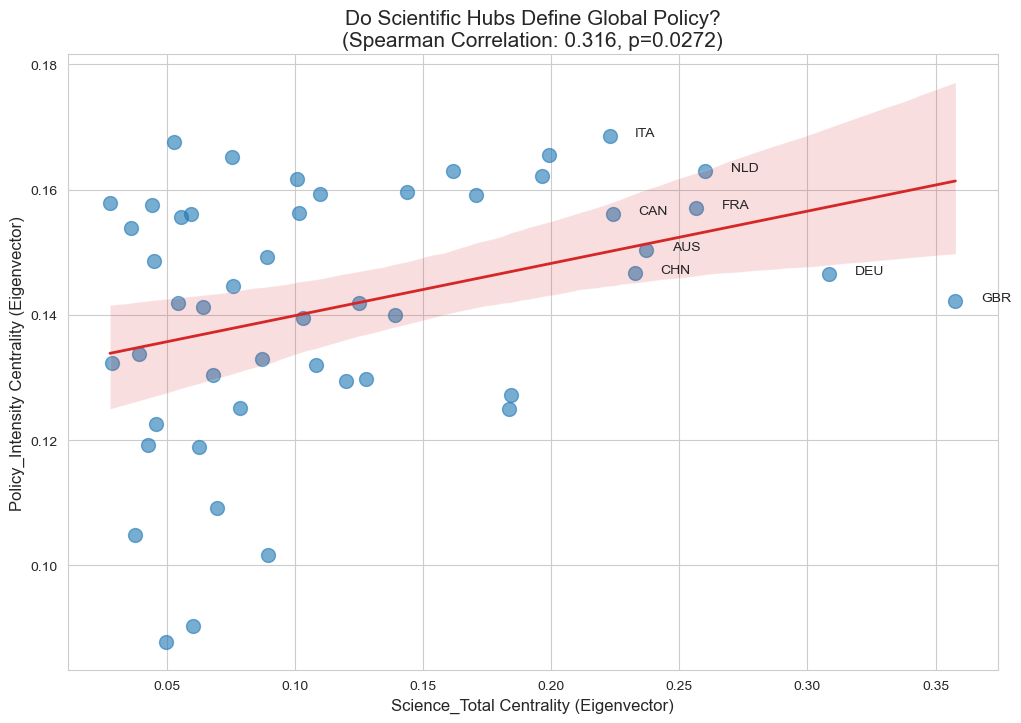

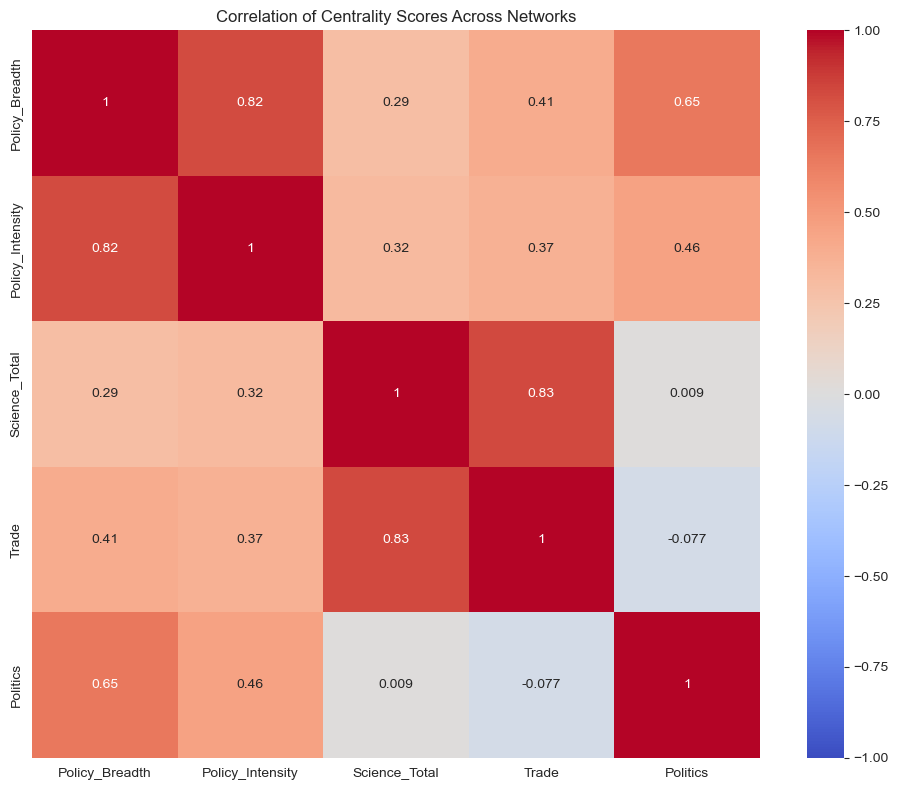

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import pearsonr, spearmanr

# ==============================================================================
# 1. 配置与路径
# ==============================================================================
INPUT_FOLDER = '../../data/PDF_data_Visual/Long_dataframe'
OUTPUT_FOLDER = '../../data/Node_Level_Analysis'

if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

# 定义我们要对比的网络
NETWORKS = {
    # 政策网络 (因变量)
    'Policy_Breadth': '4-1-overlapping_cluster_heatmap_Breadth_long.csv',
    'Policy_Intensity': '4-1-overlapping_cluster_heatmap_Intensity_long.csv',
    
    # 解释网络 (自变量)
    'Science_Total': '1-7-All-Paper_collab-Total_long.csv',
    'Trade': '1-2-BACI_Trade_Intensity_Avg_long.csv',
    'Politics': '1-1-norm_ideal_sim_2005_2023_long.csv'
}

# ==============================================================================
# 2. 计算中心度的函数
# ==============================================================================
def get_centrality_scores(filepath, metric='eigenvector'):
    """
    读取长格式 CSV，构建网络，计算每个国家的中心度
    """
    try:
        df = pd.read_csv(filepath)
        # 清理列名
        df.columns = [c.strip() for c in df.columns]
        
        # 构建图
        G = nx.Graph() # 假设是无向图，如果是有向图用 nx.DiGraph()
        for _, row in df.iterrows():
            if row['Weight'] > 0: # 只添加有权重的边
                G.add_edge(str(row['Source']), str(row['Target']), weight=row['Weight'])
        
        # 计算中心度
        if metric == 'eigenvector':
            # 特征向量中心度：衡量节点的“影响力”
            try:
                cent = nx.eigenvector_centrality_numpy(G, weight='weight')
            except:
                # 如果不收敛，退化为度中心度
                cent = nx.degree_centrality(G)
        elif metric == 'degree':
            # 加权度中心度：衡量节点的“活跃度”
            cent = dict(G.degree(weight='weight'))
            
        return pd.Series(cent, name='Score')
    
    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        return None

# ==============================================================================
# 3. 主程序
# ==============================================================================
def main():
    print("Calculating Network Centrality for all countries...")
    
    # 1. 计算所有网络的中心度
    results = pd.DataFrame()
    
    for name, filename in NETWORKS.items():
        path = os.path.join(INPUT_FOLDER, filename)
        if os.path.exists(path):
            print(f"Processing {name}...")
            scores = get_centrality_scores(path, metric='eigenvector')
            if scores is not None:
                scores.name = name
                results = pd.merge(results, scores, left_index=True, right_index=True, how='outer') if not results.empty else pd.DataFrame(scores)
    
    # 填充 NaN (孤立节点)
    results = results.fillna(0)
    
    # 保存原始数据
    results.to_csv(os.path.join(OUTPUT_FOLDER, 'Country_Centrality_Scores.csv'))
    print(f"Aligned {len(results)} countries.")

    # 2. 重点分析：科研中心度 vs 政策中心度
    # 我们来看看 Science_Total 是否能预测 Policy_Intensity
    
    target_y = 'Policy_Intensity' # 你可以改成 Breadth
    target_x = 'Science_Total'
    
    if target_y in results.columns and target_x in results.columns:
        plt.figure(figsize=(12, 8))
        sns.set_style("whitegrid")
        
        # 计算相关性
        r, p = spearmanr(results[target_x], results[target_y])
        
        # 散点图
        sns.regplot(data=results, x=target_x, y=target_y, 
                    scatter_kws={'s': 100, 'alpha': 0.6, 'color': '#1f77b4'},
                    line_kws={'color': '#d62728', 'linewidth': 2})
        
        # 标注国家名 (只标注比较极端的点，避免拥挤)
        for country, row in results.iterrows():
            # 简单的筛选：离对角线远或者数值很大的点
            if row[target_x] > 0.2 or row[target_y] > 0.2:
                plt.text(row[target_x]+0.01, row[target_y], country, fontsize=10)

        plt.title(f"Do Scientific Hubs Define Global Policy?\n(Spearman Correlation: {r:.3f}, p={p:.4f})", fontsize=15)
        plt.xlabel(f"{target_x} Centrality (Eigenvector)", fontsize=12)
        plt.ylabel(f"{target_y} Centrality (Eigenvector)", fontsize=12)
        
        save_path = os.path.join(OUTPUT_FOLDER, 'Science_vs_Policy_Centrality.png')
        plt.savefig(save_path, dpi=300)
        print(f"Plot saved: {save_path}")
        
    # 3. 生成相关性热力图 (所有维度)
    plt.figure(figsize=(10, 8))
    corr_mat = results.corr(method='spearman')
    sns.heatmap(corr_mat, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True)
    plt.title("Correlation of Centrality Scores Across Networks")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_FOLDER, 'Centrality_Correlation_Matrix.png'))

if __name__ == "__main__":
    main()

Calculating Network Centrality for all countries...
Processing Policy_Center...
Processing Science_Hub...
Processing Trade_Hub...
Processing Politics_Hub...
Aligned 49 countries.
Plot saved: ../../data/Node_Level_Analysis\Science_vs_Policy_Centrality.png


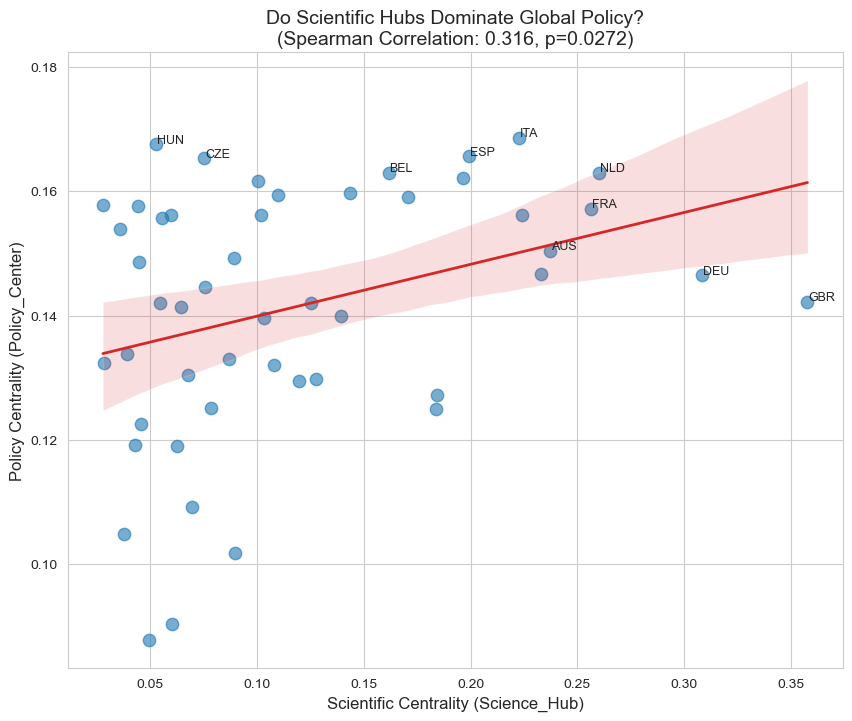

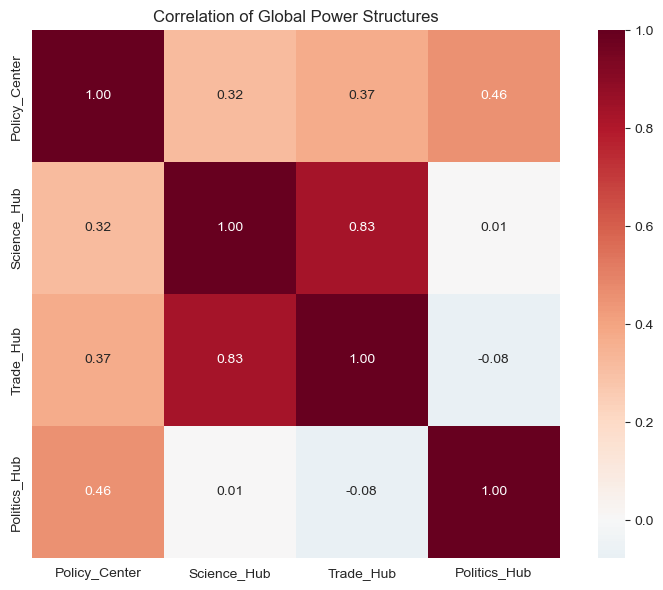

In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import pearsonr, spearmanr

# ==============================================================================
# 1. 配置与路径
# ==============================================================================
INPUT_FOLDER = '../../data/PDF_data_Visual/Long_dataframe'
OUTPUT_FOLDER = '../../data/Node_Level_Analysis'

if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

# 定义我们要对比的网络 (左边是自变量，右边是因变量)
NETWORKS = {
    # [Y] 政策网络: 衡量谁是政策的“中心/源头”
    'Policy_Center': '4-1-overlapping_cluster_heatmap_Intensity_long.csv',
    
    # [X] 解释网络: 衡量谁是其他领域的“中心”
    'Science_Hub': '1-7-All-Paper_collab-Total_long.csv',
    'Trade_Hub': '1-2-BACI_Trade_Intensity_Avg_long.csv',
    'Politics_Hub': '1-1-norm_ideal_sim_2005_2023_long.csv'
}

# ==============================================================================
# 2. 计算中心度的函数
# ==============================================================================
def get_centrality_scores(filepath, metric='eigenvector'):
    """
    读取长格式 CSV，构建网络，计算每个国家的中心度
    """
    try:
        df = pd.read_csv(filepath)
        df.columns = [c.strip() for c in df.columns]
        
        # 构建图 (无向加权图)
        G = nx.Graph() 
        for _, row in df.iterrows():
            if row['Weight'] > 0: 
                G.add_edge(str(row['Source']), str(row['Target']), weight=row['Weight'])
        
        # 计算中心度
        if metric == 'eigenvector':
            # 特征向量中心度：不仅看你有多少邻居，还看你的邻居牛不牛
            # 这是衡量“影响力”的最佳指标
            try:
                cent = nx.eigenvector_centrality_numpy(G, weight='weight')
            except:
                # 备用方案
                cent = nx.degree_centrality(G)
        elif metric == 'degree':
            cent = dict(G.degree(weight='weight'))
            
        return pd.Series(cent, name='Score')
    
    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        return None

# ==============================================================================
# 3. 主程序
# ==============================================================================
def main():
    print("Calculating Network Centrality for all countries...")
    
    # 1. 计算所有网络的中心度
    results = pd.DataFrame()
    
    for name, filename in NETWORKS.items():
        path = os.path.join(INPUT_FOLDER, filename)
        if os.path.exists(path):
            print(f"Processing {name}...")
            scores = get_centrality_scores(path, metric='eigenvector')
            if scores is not None:
                scores.name = name
                # 合并到总表
                if results.empty:
                    results = pd.DataFrame(scores)
                else:
                    results = pd.merge(results, scores, left_index=True, right_index=True, how='outer')
    
    # 填充 NaN (孤立节点设为0)
    results = results.fillna(0)
    
    # 保存原始分数
    results.to_csv(os.path.join(OUTPUT_FOLDER, 'Country_Centrality_Scores.csv'))
    print(f"Aligned {len(results)} countries.")

    # 2. 重点分析：科研中心度 (X) vs 政策中心度 (Y)
    target_y = 'Policy_Center' 
    target_x = 'Science_Hub'
    
    if target_y in results.columns and target_x in results.columns:
        plt.figure(figsize=(10, 8))
        sns.set_style("whitegrid")
        
        # 计算相关性
        r, p = spearmanr(results[target_x], results[target_y])
        
        # 绘制回归散点图
        ax = sns.regplot(data=results, x=target_x, y=target_y, 
                         scatter_kws={'s': 80, 'alpha': 0.6, 'color': '#1f77b4'},
                         line_kws={'color': '#d62728', 'linewidth': 2})
        
        # 标注显眼的国家 (右上角的大国，或者偏离线很远的国家)
        # 简单的自动标注逻辑：数值大或者残差大的点
        texts = []
        for country, row in results.iterrows():
            x, y = row[target_x], row[target_y]
            # 标注规则：X或Y比较大
            if x > results[target_x].quantile(0.9) or y > results[target_y].quantile(0.9):
                texts.append(plt.text(x, y, country, fontsize=9))

        # 调整标签防止重叠 (如果安装了 adjustText 库最好，这里用简单版)
        try:
            from adjustText import adjust_text
            adjust_text(texts, arrowprops=dict(arrowstyle='-', color='grey'))
        except ImportError:
            pass # 如果没有安装 adjustText 就保持原样

        plt.title(f"Do Scientific Hubs Dominate Global Policy?\n(Spearman Correlation: {r:.3f}, p={p:.4f})", fontsize=14)
        plt.xlabel(f"Scientific Centrality ({target_x})", fontsize=12)
        plt.ylabel(f"Policy Centrality ({target_y})", fontsize=12)
        
        save_path = os.path.join(OUTPUT_FOLDER, 'Science_vs_Policy_Centrality.png')
        plt.savefig(save_path, dpi=300)
        print(f"Plot saved: {save_path}")
        
    # 3. 还有一个“彩蛋”图：相关性矩阵热力图
    # 看看哪种力量（贸易、政治、科研）和政策地位最相关？
    plt.figure(figsize=(8, 6))
    corr_mat = results.corr(method='spearman')
    
    sns.heatmap(corr_mat, annot=True, cmap='RdBu_r', center=0, fmt='.2f', square=True)
    plt.title("Correlation of Global Power Structures")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_FOLDER, 'Centrality_Correlation_Matrix.png'))

if __name__ == "__main__":
    main()

In [7]:
!pip install python-louvain

Looking in indexes: https://mirrors.sustech.edu.cn/pypi/web/simple
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9474 sha256=33ac299006007779e21f12a8f4678548c43ea266c4fe5b80baf79df868a8e5a0
  Stored in directory: c:\users\28274\appdata\local\pip\cache\wheels\6b\8c\a9\79d1d8a7f78a025b243d8f179f553a79f0ba87113f795de194
Successfully built python-louvain


Detecting Science Clubs...
Detecting Policy Clubs...
Analysis complete. Check the Heatmap in ../../data/Club_Analysis

一句话解释：如果图中对角线很亮，说明科学合作直接决定了政策阵营。


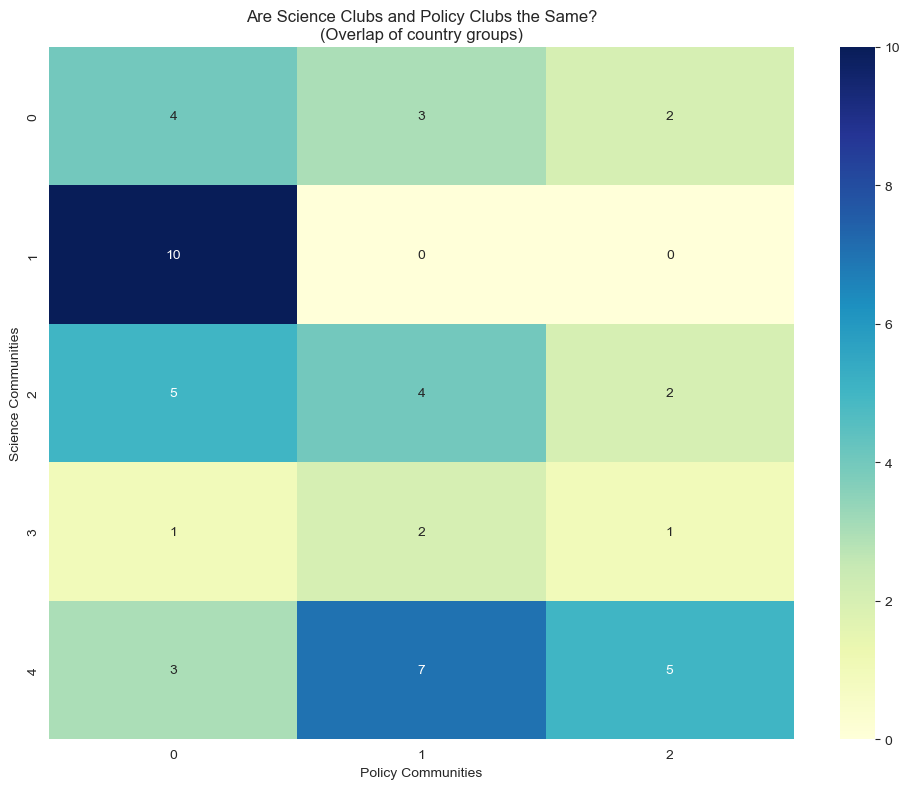

In [8]:
import pandas as pd
import numpy as np
import networkx as nx
import community as community_louvain # 需要安装 python-louvain
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
import os

# ==============================================================================
# 1. 核心逻辑：对比“科学俱乐部”和“政策俱乐部”
# ==============================================================================
INPUT_FOLDER = '../../data/PDF_data_Visual/Long_dataframe'
OUTPUT_FOLDER = '../../data/Club_Analysis'

if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

def get_clusters(filepath, threshold_percentile=75):
    """
    读取网络，检测社区（圈子）
    """
    df = pd.read_csv(filepath)
    df.columns = [c.strip() for c in df.columns]
    
    # 过滤掉弱连接，只看强关系，圈子才清晰
    threshold = np.percentile(df['Weight'], threshold_percentile)
    df_strong = df[df['Weight'] > threshold]
    
    G = nx.from_pandas_edgelist(df_strong, 'Source', 'Target', ['Weight'])
    
    # 使用 Louvain 算法自动找圈子
    partition = community_louvain.best_partition(G, weight='Weight')
    return partition, G

# ==============================================================================
# 2. 运行分析
# ==============================================================================
def main():
    # 我们对比：论文合作网 vs 政策强度网
    science_file = os.path.join(INPUT_FOLDER, '1-7-All-Paper_collab-Total_long.csv')
    policy_file = os.path.join(INPUT_FOLDER, '4-1-overlapping_cluster_heatmap_Intensity_long.csv')

    print("Detecting Science Clubs...")
    sci_clusters, G_sci = get_clusters(science_file)
    
    print("Detecting Policy Clubs...")
    pol_clusters, G_pol = get_clusters(policy_file)

    # 汇总到一起
    all_countries = set(sci_clusters.keys()) & set(pol_clusters.keys())
    comparison = pd.DataFrame({
        'Science_Club': [sci_clusters[c] for c in all_countries],
        'Policy_Club': [pol_clusters[c] for c in all_countries]
    }, index=list(all_countries))

    # 保存结果
    comparison.to_csv(os.path.join(OUTPUT_FOLDER, 'Club_Comparison.csv'))

    # ==============================================================================
    # 3. 直观可视化：桑基图逻辑（谁从科学圈跳到了另一个政策圈）
    # ==============================================================================
    # 这里我们用一个矩阵热力图来展示重合度
    # 纵轴是科学圈，横轴是政策圈，格子越亮说明两个圈子重合度越高
    cross_tab = pd.crosstab(comparison['Science_Club'], comparison['Policy_Club'])
    
    import seaborn as sns
    plt.figure(figsize=(10, 8))
    sns.heatmap(cross_tab, annot=True, cmap="YlGnBu", fmt='d')
    plt.title("Are Science Clubs and Policy Clubs the Same?\n(Overlap of country groups)")
    plt.xlabel("Policy Communities")
    plt.ylabel("Science Communities")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_FOLDER, 'Club_Consistency_Heatmap.png'))
    
    print(f"Analysis complete. Check the Heatmap in {OUTPUT_FOLDER}")
    print("\n一句话解释：如果图中对角线很亮，说明科学合作直接决定了政策阵营。")

if __name__ == "__main__":
    main()

In [23]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import os
import itertools

# ==============================================================================
# 1. 基础配置
# ==============================================================================
INPUT_FOLDER = '../../data/PDF_data_Visual/Long_dataframe'
OUTPUT_FOLDER = '../../data/Quantile_NoJitter_Final'

if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

# 完整的变量映射
FILES_MAP = {
    # DV (Y)
    'Y_Intensity': '4-1-overlapping_cluster_heatmap_Intensity_long.csv',
    'Y_Breadth':   '4-1-overlapping_cluster_heatmap_Breadth_long.csv',
    
    # IVs (X)
    'Ideal_Sim':   '1-1-norm_ideal_sim_2005_2023_long.csv',
    'Geo_Prox':    '1-3-norm_geographical_proximity_avg_long.csv',
    'Lang_Off':    '1-4a-Common_Official_Language_long.csv',
    'Lang_Ethno':  '1-4b-Common_Ethno_Language_long.csv',
    
    'Trade_Int':   '1-2-BACI_Trade_Intensity_Avg_long.csv',
    'Flight_Int':  '1-5-AeroSCOPE_Flight_Intensity_long.csv',
    
    'GDP_Diff':    '1-6-1-GDP_Diff_long.csv',
    'GHG_Diff':    '1-6-2-GHG_Diff_long.csv',
    'Rent_Diff':   '1-6-3-Rent_Diff_long.csv',
    'Fuel_Diff':   '1-6-4-Fuel_Ex_Diff_long.csv',
    
    'Paper_Total': '1-7-All-Paper_collab-Total_long.csv',
    'Paper_Econ':  '1-7-T10471-Paper_collab-Climate_Change_Policy_and_Economics_long.csv',
    'Paper_Comm':  '1-7-T11488-Paper_collab-Climate_Communication_and_Perception_long.csv',
    'Paper_Sus':   '1-7-T12013-Paper_collab-Sustainable_Development_and_Env_Policy_long.csv',
    'Paper_Adapt': '1-7-T12656-Paper_collab-Climate_Adaptation_and_Migration_long.csv'
}

# 分位数设置
QUANTILES = [0.1, 0.25, 0.5, 0.75, 0.9]

# ==============================================================================
# 2. 数据加载与匹配
# ==============================================================================
def load_data():
    print("Loading Data...")
    data_dict = {}
    for var, filename in FILES_MAP.items():
        path = os.path.join(INPUT_FOLDER, filename)
        if not os.path.exists(path):
            print(f"Warning: Missing {filename}")
            continue
        df = pd.read_csv(path)
        df.columns = [c.strip() for c in df.columns]
        # 构造唯一键 Pair_Key
        df['Pair_Key'] = df.apply(lambda x: "_".join(sorted([str(x['Source']), str(x['Target'])])), axis=1)
        df = df[df['Source'] != df['Target']]
        data_dict[var] = df.set_index('Pair_Key')['Weight']

    # 合并数据
    full_df = pd.DataFrame(data_dict).dropna()
    print(f"Data Merged. Total Samples (N): {len(full_df)}")
    
    # 既然你说了所有变量都已经是 0-1，那这里就不做 Log 处理
    # 但是为了让回归系数之间可以比较（比如“政治”和“贸易”谁影响大），
    # 依然建议对 X 进行 Z-score 标准化。如果你坚持用原始 0-1，可以把下面两行注释掉。
    # (注：Y 保持原始 0-1 不变，方便解释)
    x_vars = [c for c in full_df.columns if not c.startswith('Y_')]
    for x in x_vars:
        full_df[x] = (full_df[x] - full_df[x].mean()) / full_df[x].std()
        
    return full_df

# ==============================================================================
# 3. [新功能] 分位数数据分布诊断
# ==============================================================================
def inspect_quantile_distribution(df, y_name):
    """
    回答你的疑问：每个分位数下，具体的Y值是多少？有多少个数据点是一样的？
    """
    print(f"\n=== Diagnostic: Quantile Distribution for {y_name} ===")
    print(f"{'Quantile':<10} | {'Y Value':<10} | {'Exact Matches':<15} | {'Data % (CDF)':<15}")
    print("-" * 60)
    
    total_n = len(df)
    
    for q in QUANTILES:
        # 计算该分位点的数值 (interpolation='nearest' 保证取到真实存在的数值)
        y_val = df[y_name].quantile(q, interpolation='nearest')
        
        # 统计有多少个国家对正好等于这个值
        count_exact = len(df[df[y_name] == y_val])
        
        # 统计有多少个国家对小于等于这个值 (CDF)
        count_cumulative = len(df[df[y_name] <= y_val])
        percent_cumulative = (count_cumulative / total_n) * 100
        
        print(f"{q:<10} | {y_val:.4f}     | {count_exact:<15} | {percent_cumulative:.1f}%")
        
    print("-" * 60)
    print("Interpretation: 'Exact Matches' shows how many pairs share this specific Y value.")
    print("If multiple quantiles have the same Y Value, the regression might be unstable.")
    print("-" * 60)

# ==============================================================================
# 4. 单变量与交互项回归 (无 Jitter)
# ==============================================================================
def run_analysis(df, target_y):
    # 先做诊断
    inspect_quantile_distribution(df, target_y)
    
    x_vars = [c for c in df.columns if not c.startswith('Y_')]
    results = []
    
    print(f"Running Regression for {target_y}...")

    # --- Part A: 单个变量轮询 (Single Variable) ---
    for x in x_vars:
        formula = f"{target_y} ~ {x}"
        
        try:
            # OLS
            ols = smf.ols(formula, data=df).fit()
            
            # Quantile Regression
            for q in QUANTILES:
                try:
                    # 注意：去掉Jitter后，这里可能报错"Singular matrix"，需要try-except
                    mod = smf.quantreg(formula, data=df)
                    # 增加迭代次数，放宽收敛条件，应对0-1离散数据
                    res = mod.fit(q=q, max_iter=5000, p_tol=1e-6)
                    
                    results.append({
                        'Group': 'Single',
                        'Variable': x,
                        'Quantile': q,
                        'Coef': res.params[x],
                        'Lower': res.conf_int().loc[x, 0],
                        'Upper': res.conf_int().loc[x, 1],
                        'OLS': ols.params[x]
                    })
                except Exception as e:
                    # 如果某个分位数算不出来（通常是因为数据在该分位数没变化），就跳过
                    # print(f"  Skipped q={q} for {x}: {str(e)[:50]}")
                    pass
        except:
            pass

    # --- Part B: 两两交互项 (Interaction Combinations) ---
    # 排列组合所有 X 变量
    combinations = list(itertools.combinations(x_vars, 2))
    print(f"Processing {len(combinations)} Interaction Pairs...")
    
    for va, vb in combinations:
        # 公式：Y ~ A + B + A:B
        formula = f"{target_y} ~ {va} + {vb} + {va}:{vb}"
        inter_term = f"{va}:{vb}"
        
        try:
            ols = smf.ols(formula, data=df).fit()
            
            # 只在OLS显著或者你有特定兴趣时才跑分位数，这里为了完整全跑
            # 如果跑得太慢，可以加一个 if ols.pvalues[inter_term] < 0.1: ...
            
            for q in QUANTILES:
                try:
                    mod = smf.quantreg(formula, data=df)
                    res = mod.fit(q=q, max_iter=5000, p_tol=1e-6)
                    
                    if inter_term in res.params:
                        results.append({
                            'Group': 'Interaction',
                            'Variable': f"{va} x {vb}", # 组合名
                            'Quantile': q,
                            'Coef': res.params[inter_term],
                            'Lower': res.conf_int().loc[inter_term, 0],
                            'Upper': res.conf_int().loc[inter_term, 1],
                            'OLS': ols.params.get(inter_term, 0)
                        })
                except:
                    pass
        except:
            pass

    return pd.DataFrame(results)

# ==============================================================================
# 5. 绘图 (5列布局)
# ==============================================================================
def plot_results(res_df, target_name):
    if res_df.empty:
        print("No results to plot.")
        return

    # 分组绘制：先画 Single，再画 Interaction
    groups = res_df['Group'].unique()
    
    for grp in groups:
        subset = res_df[res_df['Group'] == grp]
        unique_vars = subset['Variable'].unique()
        
        # 分页逻辑：每页最多 20 个图 (5列 x 4行)
        batch_size = 20
        for page, i in enumerate(range(0, len(unique_vars), batch_size)):
            batch_vars = unique_vars[i : i + batch_size]
            
            cols = 5
            rows = int(np.ceil(len(batch_vars) / cols))
            
            fig, axes = plt.subplots(rows, cols, figsize=(25, 4 * rows))
            axes = axes.flatten() if len(batch_vars) > 1 else [axes]
            
            for idx, var in enumerate(batch_vars):
                ax = axes[idx]
                data = subset[subset['Variable'] == var]
                
                # OLS Line
                if not data['OLS'].isnull().all():
                    ols_val = data['OLS'].iloc[0]
                    ax.axhline(ols_val, color='blue', ls='--', alpha=0.6, label='OLS')
                
                # Quantile Trend
                ax.plot(data['Quantile'], data['Coef'], 'o-', color='#d62728', lw=2)
                ax.fill_between(data['Quantile'], data['Lower'], data['Upper'], color='#d62728', alpha=0.2)
                
                # Ref Line
                ax.axhline(0, color='k', lw=1, alpha=0.5)
                
                # Style
                title = var.replace('Paper_', 'P_').replace('Diff', 'D') # 缩短标题
                ax.set_title(title, fontsize=10, fontweight='bold')
                ax.set_xticks(QUANTILES)
                
                if grp == 'Interaction':
                    ax.set_facecolor('#f0f4c3') # 浅绿色背景区分交互项
                
                if idx == 0: ax.legend()

            # 清理空白子图
            for j in range(idx + 1, len(axes)):
                fig.delaxes(axes[j])
            
            plt.suptitle(f"{target_name} - {grp} Analysis (Page {page+1})", fontsize=16, y=1.02)
            plt.tight_layout()
            save_path = os.path.join(OUTPUT_FOLDER, f"{target_name}_{grp}_Page{page+1}.png")
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            plt.close()
            print(f"Saved: {save_path}")

# ==============================================================================
# Main
# ==============================================================================
def main():
    df = load_data()
    
    # 1. 跑 Y_Intensity
    if 'Y_Intensity' in df.columns:
        res = run_analysis(df, 'Y_Intensity')
        res.to_csv(os.path.join(OUTPUT_FOLDER, 'Results_Intensity.csv'), index=False)
        plot_results(res, 'Y_Intensity')
        
    # 2. 跑 Y_Breadth
    if 'Y_Breadth' in df.columns:
        res = run_analysis(df, 'Y_Breadth')
        res.to_csv(os.path.join(OUTPUT_FOLDER, 'Results_Breadth.csv'), index=False)
        plot_results(res, 'Y_Breadth')

    print("\nAll Done.")

if __name__ == "__main__":
    main()

Loading Data...
Data Merged. Total Samples (N): 2352

=== Diagnostic: Quantile Distribution for Y_Intensity ===
Quantile   | Y Value    | Exact Matches   | Data % (CDF)   
------------------------------------------------------------
0.1        | 0.3962     | 142             | 10.1%
0.25       | 0.5805     | 224             | 27.8%
0.5        | 0.7018     | 306             | 52.1%
0.75       | 0.8305     | 194             | 83.1%
0.9        | 0.8649     | 194             | 91.3%
------------------------------------------------------------
Interpretation: 'Exact Matches' shows how many pairs share this specific Y value.
If multiple quantiles have the same Y Value, the regression might be unstable.
------------------------------------------------------------
Running Regression for Y_Intensity...
Processing 105 Interaction Pairs...
Saved: ../../data/Quantile_NoJitter_Final\Y_Intensity_Single_Page1.png
Saved: ../../data/Quantile_NoJitter_Final\Y_Intensity_Interaction_Page1.png
Saved: ../../